## NL to BI Architecture. 

Looker symantic layer can be a good helper to convert natural language to SQL and show a dashboard dependent on the given query. 


In [1]:
#!pip install looker-sdk
#!pip install google-cloud-aiplatform langchain

In [2]:
question = "생성일 기준 2022년으로, 월별로, 건설업, 제조업에 대한 연금합계를 보여줘."

In [3]:
import looker_sdk

sdk = looker_sdk.init31()  # or init40() for the older v3.1 API
my_user = sdk.me()

In [4]:
def listup_explore(model_name):
  
  return sdk.all_projects()

In [5]:
from pprint import pprint

for lookml_model in sdk.all_lookml_models():
  pprint(lookml_model.explores)

[]
[LookmlModelNavExplore(name='postal_location', description=None, label='Postal Location', hidden=False, group_label='Lookml Hol Sample', can={}),
 LookmlModelNavExplore(name='bizcategory', description='This view includes business category used in Korea. From Level 1(biggest category) to Level 3(smallest sub category).', label='Bizcategory', hidden=False, group_label='Lookml Hol Sample', can={}),
 LookmlModelNavExplore(name='national_pension_mom', description='This model explore shows the national pension information - pension amount, lost member count, added member count, business category and geolocations.', label='National Pension Mom', hidden=False, group_label='Lookml Hol Sample', can={})]
[]


In [6]:
# TODO : Implement this function with RAG architecture.

def get_right_explore(question):
  lookml_explore = "national_pension_mom"
  lookml_model = "lookml_hol_sample"
  return lookml_model, lookml_explore

lookml_model, lookml_explore = get_right_explore(question)  

In [7]:
def get_field_values(model_name, explore_name):

  # API Call to pull in metadata about fields in a particular explore
  explore = sdk.lookml_model_explore(
    lookml_model_name=model_name,
    explore_name=explore_name,
    fields="id, name, description, fields",
  )

  my_fields = []

  # Iterate through the field definitions and pull in the description, sql,
  # and other looker tags you might want to include in  your data dictionary.
  if explore.fields and explore.fields.dimensions:
    for dimension in explore.fields.dimensions:
      dim_def = {
        "field_type": "Dimension",
        "view_name": dimension.view_label,
        "field_name": dimension.name,
        "type": dimension.type,
        "description": dimension.description,
        #"sql": dimension.sql,
      }
      my_fields.append(dim_def)
  if explore.fields and explore.fields.measures:
    for measure in explore.fields.measures:
      mes_def = {
        "field_type": "Measure",
        "view_name": measure.view_label,
        "field_name": measure.name,
        "type": measure.type,
        "description": measure.description,
        #"sql": measure.sql,
      }
      my_fields.append(mes_def)
  if explore.fields and explore.fields.parameters:
    for parameter in explore.fields.parameters:
      par_def = {
        "field_type": "Parameter",
        "view_name": parameter.view_label,
        "field_name": parameter.name,
        "default_filter_value": parameter.default_filter_value,
        "type": parameter.type,
        "description": parameter.description,
        #"sql": parameter.sql,
      }
      my_fields.append(par_def)
  return my_fields

In [8]:
# for lookml_model in sdk.all_lookml_models():
#   print('lookml model name:' + lookml_model.name)
#   for one_explore in lookml_model.explores:
#     print('explore name:' + one_explore.name)
#     pprint(get_field_values(lookml_model.name, one_explore.name))
fields = get_field_values(lookml_model, lookml_explore)

In [9]:
import vertexai
from langchain.chat_models import ChatVertexAI
from langchain.llms import VertexAI
import os

PROJECT_ID = os.getenv("PROJECT_ID")  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")

llm_vertex = VertexAI(
    #model_name="text-bison@latest",
    model_name="text-bison-32k",
    max_output_tokens=8000,
    temperature=0,
    top_p=0.8,
    top_k=40,
)


In [10]:
llm = llm_vertex

In [11]:
def choose_right_fields(fields, question):
  sample_json = """
{
  "dimensions": [
    "dimension1",
  ],
  "measures": [
    "measure1",
  ],
  "filters": [
    {
      "field_name": "field_name1",
      "values": [
        "value1"
      ]
    }
  ],
  "sorts": [
    {
      "field_name": "field_name1",
      "direction": "asc"
    }
  ],
  "parameters": [
    "param1",
  ],
  "pivots": [
    "field1"
  ],
  "hidden_fields": [
    "field1"
  ]
}
  """

  prompt_template = """As a looker developer, choose right dimesions and measures for the question below. 
  You should choose right fields as least as possible and sort fields must be choosen in the dimension fields.

  fields : {fields}

  question: {question}

  answer format: json
  {sample_json}
  """
  response = llm.predict(prompt_template.format(fields=fields, question=question, sample_json=sample_json))
  return response




In [12]:
# Test Code.
# get_field_values(lookml_model, lookml_explore)


In [13]:
schema_fields = get_field_values(lookml_model, lookml_explore)
response = choose_right_fields(fields=schema_fields, question=question) #S


In [14]:
response

' ```json\n{\n  "dimensions": [\n    "national_pension_mom.data_create_yearmonth_year",\n    "national_pension_mom.data_create_yearmonth_month",\n    "bizcategory.cat_l1"\n  ],\n  "measures": [\n    "national_pension_mom.total_monthly_fixed_amount"\n  ],\n  "filters": [\n    {\n      "field_name": "national_pension_mom.data_create_yearmonth_year",\n      "values": [\n        "2022"\n      ]\n    },\n    {\n      "field_name": "bizcategory.cat_l1",\n      "values": [\n        "건설업",\n        "제조업"\n      ]\n    }\n  ],\n  "sorts": [\n    {\n      "field_name": "national_pension_mom.data_create_yearmonth_month",\n      "direction": "asc"\n    }\n  ],\n  "parameters": [],\n  "pivots": [],\n  "hidden_fields": []\n}\n```'

In [15]:
def get_field_type(field_name, schema_fields):
  for field in schema_fields:
    if field['field_name'] == field_name:
      return field['type']

In [16]:
from langchain.output_parsers import PydanticOutputParser
from langchain.pydantic_v1 import BaseModel, Field, validator
from typing import List

class LookerFilterValue(BaseModel):
  field_name: str = Field(description="field_name")
  values: List[str] = Field(description="values")

class LookerSortField(BaseModel):
  field_name: str = Field(description="field_name")
  direction: str = Field(description="direction")

class LookerQueryParameters(BaseModel):
  dimensions: List[str] = Field(description="dimensions")
  measures: List[str] = Field(description="measures")
  parameters: List[str] = Field(description="parameters")
  filters: List[LookerFilterValue] = Field(description="filters")
  sorts: List[LookerSortField] = Field(description="sorts")
  pivots: List[str] = Field(description="pivot - These fields are used as pivots in the chart.")
  hidden_fields: List[str] = Field(description="hidden_fields - These fields are used as filters but are not shown in the chart.")

def get_right_fields_object(response):
  parser = PydanticOutputParser(pydantic_object=LookerQueryParameters)
  return parser.parse(response)


In [17]:
related_fields = get_right_fields_object(response)

In [18]:
def decide_to_retrieve_values_for_the_filters(related_fields):
  output_sample = """
  {
    "required_target": ["field1","field2"]
  }
  """
  prompt_template = """As a looker developer, decide whether to retrieve values for the filters below. 
  For example, date / timestamp columns don't need to retrieve values. but string columns need to retrieve values from the database.

  filter fields : {filter_fields}

  output sample : json array
  {output_sample}
  """
  response = llm.predict(prompt_template.format(filter_fields=related_fields.filters, output_sample=output_sample))
  return response

In [19]:
retrieve_target_filters = decide_to_retrieve_values_for_the_filters(related_fields)

In [20]:

class LookerFilterRetrieves(BaseModel):
  required_target: List[str] = Field(description="required_target")

def get_retrieve_target_filters_object(retrieve_target_filters):
  parser = PydanticOutputParser(pydantic_object=LookerFilterRetrieves)
  return parser.parse(retrieve_target_filters)


In [21]:
retrieve_target_filters

' ```json\n  {\n    "required_target": ["national_pension_mom.data_create_yearmonth_year", "bizcategory.cat_l1"]\n  }\n  ```'

In [22]:
def get_user_input_value_for_filter_field(related_fields, field_name):
  for filter in related_fields.filters:
    if filter.field_name == field_name:
      return filter.values
  return ""


In [ ]:
retrieve_target_filter_obj = get_retrieve_target_filters_object(retrieve_target_filters)

In [ ]:
from looker_sdk.sdk.api31 import models as ml

def get_validated_filter_values_from_looker(lookml_model, lookml_explore, retrieve_target_filter_obj):
  choose_right_filter_value_list = []
  for retrieve_target_filter in retrieve_target_filter_obj.required_target:
    print(retrieve_target_filter)
    query_template = ml.WriteQuery(model=lookml_model, view=lookml_explore,fields=[retrieve_target_filter])
    query = sdk.create_query(query_template)
    json_ = sdk.run_query(query.id, "json")
    print(json_)
    choose_right_filter_value_list.append({ retrieve_target_filter : json_})
  return choose_right_filter_value_list
    


In [ ]:
retrieve_filter_and_values = get_validated_filter_values_from_looker(lookml_model, lookml_explore, retrieve_target_filter_obj)

In [ ]:
retrieve_filter_and_values

In [ ]:
def choose_right_filter_value(filter_values, wanted_value):
  example_json = "[{\"national_pension_mom.data_create_yearmonth_year\":2022}]"
  prompt_template = """As a looker developer, choose right filter value for the wanted value below without changing filter value itself.

  example :
  {example_json}

  filter_values : {filter_values}

  wanted_values: {wanted_value}

  answer format: json array
  [filter_value1, filter_value2, ...]
  """
  response = llm.predict(prompt_template.format(example_json=example_json,filter_values=filter_values, wanted_value=wanted_value))
  return response  

In [ ]:
import json

# class LookerValidFilterValue(BaseModel):
#   field_name: str = Field(description="field_name")
#   field_values: List[str] = Field(description="field_values")

# def parse_valid_filter_values(response):
#   parser = PydanticOutputParser(pydantic_object=LookerValidFilterValue)
#   return parser.parse(response)

def parse_valid_filter_values(response):
  print('llm response:'+ response)
  start_index = response.find('[')
  end_index = response.rfind(']')
  json_data = response[start_index:end_index+1]
  parsed_json = json.loads(json_data)
  return parsed_json

In [ ]:
def get_appropriate_filter_value_pair(related_fields, retrieve_filter_and_values):
  filter_value_pair = []
  for filter_and_values in retrieve_filter_and_values:
    field_name = list(filter_and_values.keys())[0]
    #print(filter_and_values)
    user_input_value = get_user_input_value_for_filter_field(related_fields, field_name)
    #print(user_input_value)
    actual_value = choose_right_filter_value(filter_and_values, user_input_value)
    #print(actual_value)  
    value_object = parse_valid_filter_values(actual_value)
    #print(value_object)
    filter_value_pair.append(value_object)
  return filter_value_pair


In [ ]:
valid_filter_values = get_appropriate_filter_value_pair(related_fields, retrieve_filter_and_values)

In [ ]:
valid_filter_values

In [ ]:
def get_quoted_value(valid_filter_values, field_name):
  values = []
  for filter_values in valid_filter_values:
    print(filter_values)
    for filter_value in filter_values:
      field_name_cmp = list(filter_value.keys())[0]
      field_value = list(filter_value.values())[0]
      field_type = get_field_type(field_name, schema_fields)
      if field_name_cmp == field_name:
        if field_type == 'string':
          values.append(field_value)
        else:
          values.append(str(field_value))
  return ','.join(values)
  

In [ ]:
from typing import cast, Dict, List, Union


def get_lookml_filter_values(valid_filter_values, filters):
  filter_dict:Dict[str, str] = {}
  for filter in filters:
    field_name = filter.field_name
    quoted_values = get_quoted_value(valid_filter_values, field_name)
    filter.values = quoted_values
    filter_dict[field_name] = quoted_values
  return filter_dict

In [ ]:
print(get_lookml_filter_values(valid_filter_values, related_fields.filters))

In [ ]:
for sorted_column in related_fields.sorts:
  print(sorted_column)

In [ ]:
print(related_fields)

In [ ]:
def make_dimension_and_description_pair(related_fields, schema_fields):
  dimension_and_description_pair = []
  for one_dimension in related_fields.dimensions:
    for dimension in schema_fields:
      if dimension['field_name'] == one_dimension:
        dimension_and_description_pair.append((one_dimension, dimension['description']))
  return dimension_and_description_pair


In [ ]:
def choose_chart_type_and_pivots(related_fields, schema_fields, question):
  dimension_and_description_pair = make_dimension_and_description_pair(related_fields, schema_fields)
  sample_json = """{
  "chart_type": "looker_column",
  "date_time_dimensions": ["dimension1"],
  "pivots": [
    "field1"
  ],
  "hidden_fields": [
    "field1"
  ]
  "reason_to_choose": "I choose field1 as a pivot field because ..."
  }"""
  prompt_template = """As a looker developer, choose chart type and pivot fields and hidden fields in the given dimensions for the question below. 
  Pivot field is a field that is used to create a pivot table. A pivot field converts category values in the field to columns so that you can compare different category values. 
  For example, if you have sales data, you can compare sales by product by setting the "Product" field as a pivot field. Date/time fields MUST not be used as pivot fields.
  Hidden field is a field that is not displayed in a chart. Hidden fields are used to hide fields that are not needed in the chart or that can confuse users. 
  For example, the "Product ID" field can be used to identify products, but it does not need to be displayed in a chart. If there are two same date fields, one of them can be hidden. 
  At least one field must be a visible field that is not used in pivot fields or hidden fields.

  chart_types : 
  looker_column - Column charts are useful when you want to compare the values of multiple fields for multiple records. It needs one main field to show the values separated by the main field. And this field must not be a pivot field.
  looker_line - Line charts are useful when you want to show the changes in a value over time. They are also useful for comparing the changes in two or more values over time.
  looker_area - Area charts are useful when you want to compare the trends of two or more values over time. They are also useful for showing the cumulative sum of values over time.
  looker_funnel - Funnel charts are useful to understand events in a sequential process, like prospect stages in a sales pipeline, engagement with a marketing campaign, or visitor movement through a website.
  looker_pie - Pie charts are useful when you want to show the proportion of values to the total value. They are also useful for comparing the proportional differences between values.
  looker_timeline - Timeline charts are useful when you want to show events over time. They are also useful for showing the duration of events. It needs at least 3 fields. 1. Event Name 2. Start Date 3. End Date
  looker_table - Table charts are useful when you want to show the values of multiple fields for multiple records. They are also useful for showing the values of multiple fields for a single record.

  dimensions : 
  {dimensions}

  question:
  {question}

  answer format: json
  {sample_json}
  """
  prompt_full = prompt_template.format(dimensions=dimension_and_description_pair, question=question, sample_json=sample_json)
  #print(prompt_full)
  response = llm.predict(prompt_full)
  return response

In [ ]:
class LookerChartTypeClassifier(BaseModel):
  chart_type: str = Field(description="chart_type")
  date_time_dimensions: List[str] = Field(description="date_time_dimensions")
  pivots: List[str] = Field(description="pivot fields")
  hidden_fields: List[str] = Field(description="hidden fields")
  reason_to_choose: str = Field(description="reason_to_choose")

def get_looker_chart_type(reponse):
  parser = PydanticOutputParser(pydantic_object=LookerChartTypeClassifier)
  return parser.parse(response)


In [ ]:
llm_response = choose_chart_type_and_pivots(related_fields, schema_fields, question)

In [ ]:
def parse_valid_json_values(response):
  print('llm response:'+ response)
  start_index = response.find('{')
  end_index = response.rfind('}')
  json_data = response[start_index:end_index+1]
  parsed_json = json.loads(json_data)
  return parsed_json

chart_type_and_pivots = parse_valid_json_values(llm_response)

In [ ]:
# chart_type_and_pivots = get_looker_chart_type(llm_response)
chart_type_and_pivots

In [ ]:
def make_query_for_the_look(lookml_model, lookml_explore, related_fields, valid_filter_values):
  fields = []
  fields.extend(related_fields.dimensions)
  fields.extend(related_fields.measures)
  filters = get_lookml_filter_values(valid_filter_values, related_fields.filters)
  hidden_fields = chart_type_and_pivots['hidden_fields']
  pivot_fields = chart_type_and_pivots['pivots']
  chart_type = chart_type_and_pivots['chart_type']
  print('fields:' + str(fields))
  print('filters:' + str(filters))
  print('hidden_fields:' + str(hidden_fields))
  print('pivot_fields:' + str(pivot_fields))
  print('chart_type:' + str(chart_type))
  query_template = ml.WriteQuery(model=lookml_model, view=lookml_explore,fields=fields,filters=filters,pivots=pivot_fields,vis_config={'type':chart_type, 'hidden_fields':hidden_fields})
  query = sdk.create_query(query_template)
  run_response = sdk.run_inline_query("json", query)
  print('query.id:' + str(query.id))
  return query
    

In [ ]:
generated_query = make_query_for_the_look(lookml_model, lookml_explore, related_fields, valid_filter_values)
print(generated_query.id)



In [ ]:
## Caution : 'title' field should be unique for each look. You should change this field to create new look.

def create_look(question, generated_query):
  existing_look = sdk.search_looks(query_id=generated_query.id)
  if len(existing_look) > 0:
    return existing_look[0]
  new_look = sdk.create_look(ml.WriteLookWithQuery(query_id=generated_query.id, 
    description=question,
    deleted=False,
    is_run_on_load=True,
    public=True,
    folder_id=str(sdk.me().personal_folder_id),
    title=question+"generated2"))
  return new_look


In [ ]:
new_look = create_look(question, generated_query)

In [ ]:
def get_full_url(short_url):
  return 'http://localhost:8080' + short_url

print(get_full_url(new_look.short_url))

In [ ]:
for group in sdk.all_groups():
  print(group)

In [ ]:
sso_url = sdk.create_sso_embed_url(ml.EmbedSsoParams(target_url=get_full_url(new_look.short_url), group_ids=[3]))

In [ ]:
print(sso_url.url)

In [ ]:
for one_look in sdk.all_looks():
  print(one_look.title)
  query = sdk.query(one_look.query_id)
  print(query)


THe below image is a look created by the above codes. 

![alt Looker View image](resources/looker_view_8.png "Title")

## RAG Architecture with SQLs

In many cases, there are lots of SQLs already used in the business. In that, Paretto's Rule exists - small portion of SQLs are more frequently used in the real case. 
LLM can convert SQL into plain english to describe the goal of SQLs. And RAG architecture can help to search appropriate SQLs for the user's request.

I will use public dataset to show this case. 

In [23]:
#!pip install pandas
#!pip install db-dtypes
#!pip install matplotlib

In [24]:
from google.cloud import bigquery
client = bigquery.Client()

In [25]:
import pandas as pd

df_c_cpi = client.query('SELECT * FROM `bigquery-public-data.bls.cpi_u`').to_dataframe()

In [26]:
# distinct values in each columns of the dataframe
df_c_cpi.nunique()


series_id                7928
year                       25
period                     16
value                  254037
footnote_codes              1
survey_abbreviation         1
seasonal_code               2
periodicity_code            2
area_code                  64
area_name                  58
item_code                 400
item_name                 400
date                      375
dtype: int64

In [27]:
# head of the 'iten_name' column's distinct values
df_c_cpi['item_name'].unique()[:20]

array(['All items', 'Energy', 'All items less food',
       'All items less food and shelter',
       'All items less food, shelter, and energy',
       'All items less food, shelter, energy, and used cars and trucks',
       'All items less food and energy', 'All items less shelter',
       'All items less medical care', 'All items less energy',
       'Apparel less footwear', 'Apparel', "Men's and boys' apparel",
       "Women's and girls' apparel", 'Commodities', 'Energy commodities',
       'Commodities less food', 'Commodities less food and beverages',
       'Commodities less food and energy commodities',
       'Commodities less food, energy, and used cars and trucks'],
      dtype=object)

In [28]:
df_ts_cpi = df_c_cpi[(df_c_cpi['item_name'] == 'All items') & (df_c_cpi['area_name'] == 'U.S. city average')][['date', 'value']]

# convert the 'date' column to datetime type
df_ts_cpi['date'] = pd.to_datetime(df_ts_cpi['date'])

# set the 'date' column as the index of the dataframe
df_ts_cpi.set_index('date', inplace=True)


<Axes: title={'center': 'Consumer Price Index (CPI)'}, xlabel='date'>

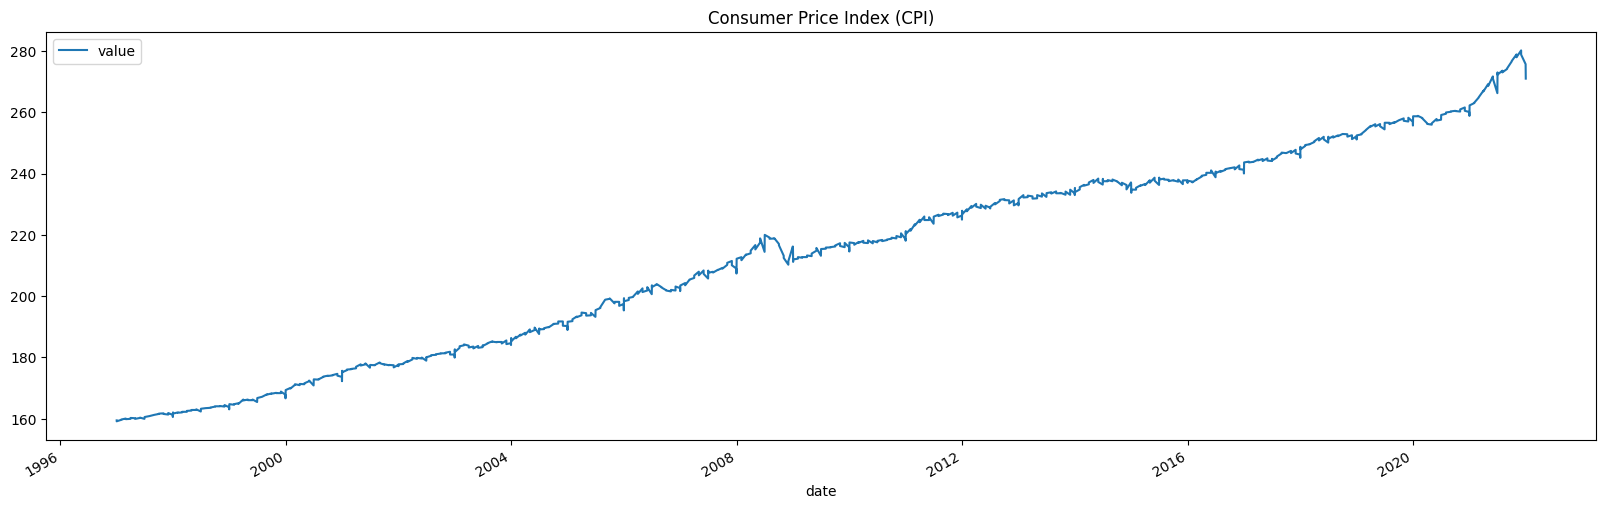

In [29]:
df_ts_cpi.plot(figsize=(20, 6), title='Consumer Price Index (CPI)')

In [30]:
# make new dataframe with item_name == 'Commodities' and area_name == 'U.S. city average'
# and select only 'date' and 'value' columns
df_ts_cpi_commodities = df_c_cpi[(df_c_cpi['item_name'] == 'Commodities') & (df_c_cpi['area_name'] == 'U.S. city average')][['date', 'value']]


<Axes: title={'center': 'Consumer Price Index (CPI) - Commodities'}, xlabel='date'>

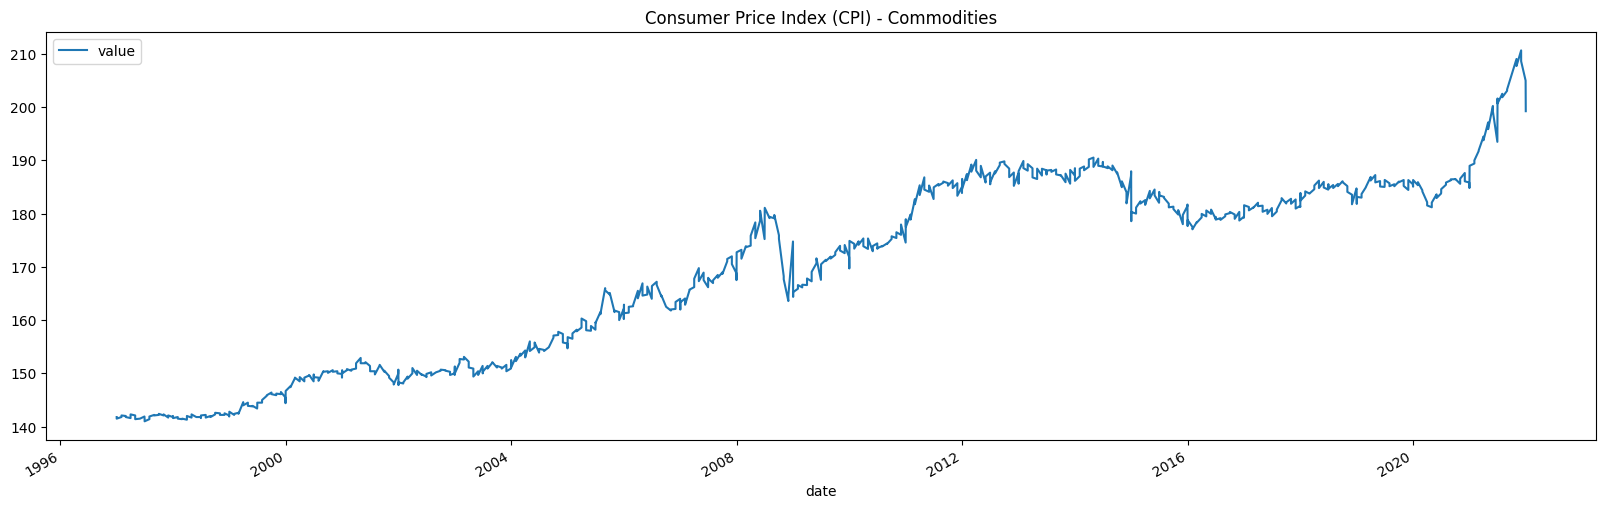

In [31]:

# convert the 'date' column to datetime type
df_ts_cpi_commodities['date'] = pd.to_datetime(df_ts_cpi_commodities['date'])

# set the 'date' column as the index of the dataframe
df_ts_cpi_commodities.set_index('date', inplace=True)

df_ts_cpi_commodities.plot(figsize=(20, 6), title='Consumer Price Index (CPI) - Commodities')

<Axes: title={'center': 'Consumer Price Index (CPI) - Food'}, xlabel='date'>

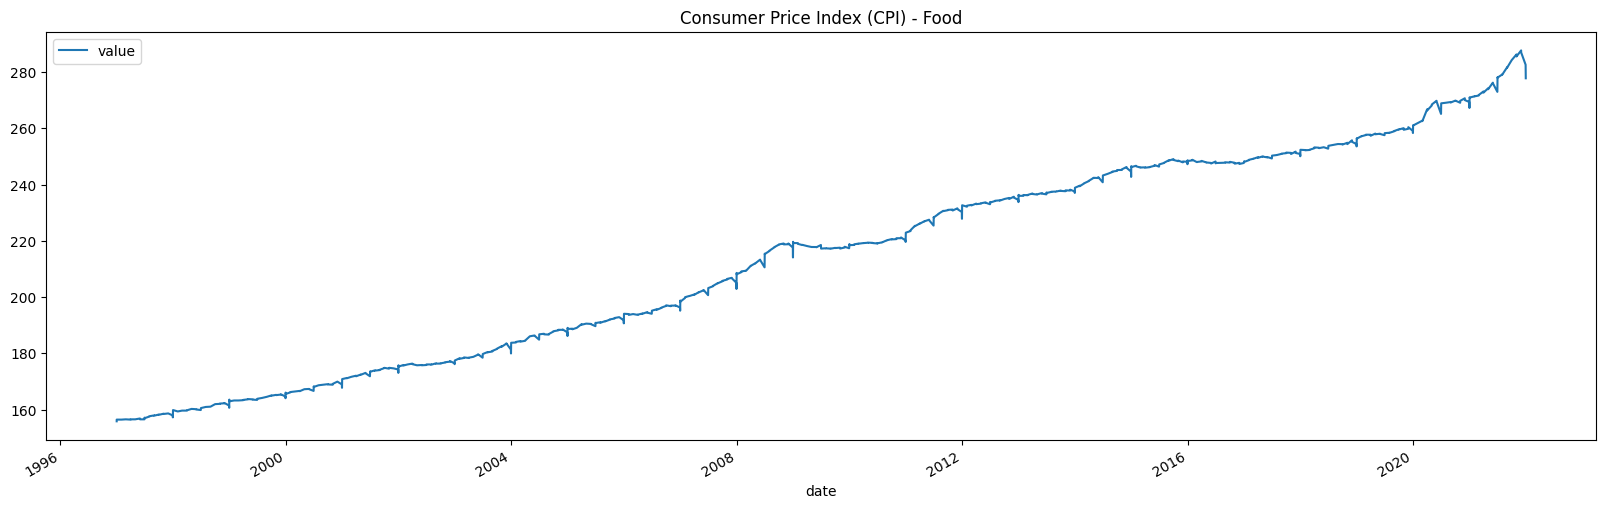

In [32]:
# make new dataframe with item_name == 'Food' and area_name == 'U.S. city average'
# and select only 'date' and 'value' columns
df_ts_cpi_food = df_c_cpi[(df_c_cpi['item_name'] == 'Food') & (df_c_cpi['area_name'] == 'U.S. city average')][['date', 'value']]
# convert the 'date' column to datetime type
df_ts_cpi_food['date'] = pd.to_datetime(df_ts_cpi_food['date'])
# set the 'date' column as the index of the dataframe
df_ts_cpi_food.set_index('date', inplace=True)
df_ts_cpi_food.plot(figsize=(20, 6), title='Consumer Price Index (CPI) - Food')

In [33]:
sql_query_average_cpi = """with tb_average_cpi as (
  select date, value from `bigquery-public-data.bls.cpi_u` where item_name = {cpi_item_name} and area_name = {us_overall_or_specific_region} order by date asc
  ), 
  select * from tb_average_cpi"""

sql_schema = """
series_id	STRING	REQUIRED				- The series id of the data. This is a unique identifier for the data series. It determine item_code / area_code / survey_abbreviation / seasonal_code / periodicity_code
year	INTEGER	NULLABLE				
period	STRING	NULLABLE				
value	FLOAT	NULLABLE				
footnote_codes	STRING	NULLABLE				
survey_abbreviation	STRING	NULLABLE				
seasonal_code	STRING	NULLABLE				
periodicity_code	STRING	NULLABLE				
area_code	STRING	NULLABLE				
area_name	STRING	NULLABLE				
item_code	STRING	NULLABLE				
item_name	STRING	NULLABLE				
date	DATE	NULLABLE	
"""

In [34]:
# !pip install pgvector
#!pip install psycopg

In [68]:
import vector_util


In [70]:
import importlib
importlib.reload(vector_util)

vdb = vector_util.VectorDatabase()

In [71]:
def convert_sql_to_description(schema, sql_query):
  sample_format = """
  {
    "description" : "The output of the query can be used to track the CPI over time for a specific item and area. It can also be used to compare the CPI for different items and areas.",
    "input_parameters" : [
      {
        "parameter_name" : "cpi_item_name",
        "parameter_type" : "string",
        "matched_column_name" : "item_name",
        "matched_table_name" : "bigquery-public-data.bls.cpi_u"
      }
    ],
    "output_values" : [
      {
        "column_name" : "registration_date",
        "column_type" : "date"
        "matched_column_name" : "sample_date",
        "matched_table_name" : "bigquery-public-data.sample2"
      }
    ]
  }
  """

  prompt_template = """As a business domain developer, convert the given sql & schema into plain english in json format.

  schema : 
  {schema}  

  sql query : 
  {sql_query}

  output format : json
  {sample_format}
  """
  response = llm.predict(prompt_template.format(schema=schema, sql_query=sql_query, sample_format=sample_format))
  return response
  

In [72]:
import json

def parse_json_response(llm_json_response) -> any:
  #print('llm response:'+ response)
  start_char = '['
  end_char = ']'
  if llm_json_response.find('[') == -1 or llm_json_response.find('{') < llm_json_response.find('[') :
    start_char = '{'
    end_char = '}'
  start_index = llm_json_response.find(start_char)
  end_index = llm_json_response.rfind(end_char)
  json_data = llm_json_response[start_index:end_index+1]
  parsed_json = json.loads(json_data)
  return parsed_json


In [73]:
sql_description = parse_json_response(convert_sql_to_description(sql_schema, sql_query_average_cpi))

In [74]:
sql_description

{'description': 'The output of the query can be used to track the CPI over time for a specific item and area. It can also be used to compare the CPI for different items and areas.',
 'input_parameters': [{'parameter_name': 'cpi_item_name',
   'parameter_type': 'string',
   'matched_column_name': 'item_name',
   'matched_table_name': 'bigquery-public-data.bls.cpi_u'},
  {'parameter_name': 'us_overall_or_specific_region',
   'parameter_type': 'string',
   'matched_column_name': 'area_name',
   'matched_table_name': 'bigquery-public-data.bls.cpi_u'}],
 'output_values': [{'column_name': 'date',
   'column_type': 'date',
   'matched_column_name': 'date',
   'matched_table_name': 'tb_average_cpi'},
  {'column_name': 'value',
   'column_type': 'float',
   'matched_column_name': 'value',
   'matched_table_name': 'tb_average_cpi'}]}

In [75]:
from langchain.embeddings import VertexAIEmbeddings

embeddings = VertexAIEmbeddings()
text = "This is a test document."

In [76]:
query_result = embeddings.embed_query(text)

In [77]:
print(type(sql_description['description']))
print(str(sql_description['description']))
print(type(embeddings.embed_query(sql_description['description'])))


<class 'str'>
The output of the query can be used to track the CPI over time for a specific item and area. It can also be used to compare the CPI for different items and areas.
<class 'list'>


In [78]:
print(embeddings.embed_query(sql_description['description']))

[-0.02595522068440914, 0.0006572342244908214, -0.023377886041998863, 0.020433232188224792, 0.027631275355815887, -0.0030629723332822323, -0.007826668210327625, -0.00043231327435933053, 0.03842558711767197, 0.024827519431710243, -0.027034303173422813, 0.010279344394803047, 0.032118748873472214, -0.04200919345021248, -0.0012781902914866805, -0.0509631484746933, 0.0017937598749995232, 0.00027060252614319324, 0.03978674113750458, -0.018073340877890587, -0.01945793256163597, 0.0051135108806192875, -0.008163293823599815, 0.024988019838929176, -0.00780998170375824, -0.08009365946054459, 0.03683385252952576, 0.016621651127934456, -0.06003792583942413, -0.008484517224133015, -0.021625490859150887, 0.02502411976456642, -0.011375430971384048, -0.019045941531658173, -0.022286009043455124, 0.07250796258449554, -0.0007727102492935956, 0.04286448284983635, 0.003474119119346142, 0.07721562683582306, 0.01902158558368683, -0.03039928339421749, 0.026833293959498405, 0.04327411204576492, -0.01610691286623

In [80]:

with vdb.get_connection() as conn:
  try:
    with conn.cursor() as cursor:
      insert_record = (sql_query_average_cpi, 
        sql_description['description'], 
        str(sql_description['input_parameters']), 
        None, 
        None, 
        str(embeddings.embed_query(sql_description['description'])).replace(' ',''))
      cursor.execute(f"INSERT INTO rag_test (sql, description, parameters, explore_view, model_name, desc_vector) VALUES ( %s, %s, %s, %s, %s, %s)", insert_record) 
  except Exception as e:
    print(e)
    conn.rollback()
  else:
    conn.commit()

# vdb.insert_record(
#   sql=sql_query_average_cpi, 
#   parameters=str(sql_description['input_parameters']), 
#   description=sql_description['description'], 
#   explore_view=None, 
#   model_name=None, 
#   desc_vector=embeddings.embed_query(sql_description['description'])
#   )

In [85]:
natural_language_question = 'show me the average CPI for all items in the overall US area.'

search_vector =  str(embeddings.embed_query(natural_language_question)).replace(' ','')
sql, description, parameters, explore_view, model_name  = vdb.select_similar_query(search_vector)

In [92]:

def get_field_unique_values(matched_table, matched_field):
  sql_query = f"select distinct {matched_field} as {matched_field} from {matched_table}"
  df = client.query(sql_query).to_dataframe()
  return df[matched_field].tolist()
  

In [89]:
import ast

list_of_parameters = ast.literal_eval(parameters)

In [90]:
list_of_parameters

[{'parameter_name': 'cpi_item_name',
  'parameter_type': 'string',
  'matched_column_name': 'item_name',
  'matched_table_name': 'bigquery-public-data.bls.cpi_u'},
 {'parameter_name': 'us_overall_or_specific_region',
  'parameter_type': 'string',
  'matched_column_name': 'area_name',
  'matched_table_name': 'bigquery-public-data.bls.cpi_u'}]

In [94]:
for parameter in list_of_parameters:
  matched_table = parameter['matched_table_name']
  matched_field = parameter['matched_column_name']
  distinct_values = get_field_unique_values(matched_table, matched_field)
  parameter['distinct_values'] = distinct_values
  

[{'parameter_name': 'cpi_item_name',
  'parameter_type': 'string',
  'matched_column_name': 'item_name',
  'matched_table_name': 'bigquery-public-data.bls.cpi_u',
  'distinct_values': ['All items',
   'Energy',
   'All items less food',
   'All items less food and shelter',
   'All items less food, shelter, and energy',
   'All items less food, shelter, energy, and used cars and trucks',
   'All items less food and energy',
   'All items less shelter',
   'All items less medical care',
   'All items less energy',
   'Apparel less footwear',
   'Apparel',
   "Men's and boys' apparel",
   "Women's and girls' apparel",
   'Commodities',
   'Energy commodities',
   'Commodities less food',
   'Commodities less food and beverages',
   'Commodities less food and energy commodities',
   'Commodities less food, energy, and used cars and trucks',
   'Durables',
   'Education and communication',
   'Education',
   'Communication',
   'Information and information processing',
   'Education and co